In [ ]:
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from matplotlib.colors import ListedColormap

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

## Reference Data

In [389]:
data_ref = np.load("./volumes/single-letter-kSys1-kEnvMax1.lambdas.tar.gz-best.npz")
data_single_letter = data_ref["qs"]

## Run Data

In [390]:
def better_mask_for(a, b):
    sa = np.sum(a, axis=-1)
    sb = np.sum(b, axis=-1)
    return sa > sb

def color_mask_for(a, b):
    sa = np.sum(a, axis=-1)
    sb = np.sum(b, axis=-1)
    
    diff = sa-sb
    max_diff = max(abs(np.min(diff)), abs(np.max(diff)))
    
    if max_diff == 0:
        return (diff*0 + .5).astype("float"), 0
    
    return ((diff / max_diff + 1) / 2).astype("float"), max_diff

# which of the above graph's points protrude further
def maximum_qs(qs_list):
    best = qs_list[0]
    
    for qs in qs_list[1:]:
        better_mask = better_mask_for(qs, best)
        best[better_mask] = qs[better_mask]
        
    return best

In [391]:
import glob, re
import itertools, operator

### All Graphs

In [148]:
files = [(fn, int(re.findall(r"kSys(\d+)", fn)[0])) for fn in glob.glob("./volumes/all-graphs*.npz")]
all_graph_data = {}
for (fn, kSys) in files:
    if not kSys in all_graph_data: all_graph_data[kSys] = []
    all_graph_data[kSys].append(np.load(fn)["qs"])
for key in all_graph_data:
    all_graph_data[key] = maximum_qs(all_graph_data[key])

### Cat Codes

In [400]:
files = glob.glob("./volumes/concatcodes*1-in-19*.npz")
print(files)
concatcodes_data = []
for fn in files:
    concatcodes_data.append(np.load(fn)["qs"])
concatcodes_data = maximum_qs(concatcodes_data)

['./volumes/concatcodes.Pj5zcGFyc2U2PDw6U19fX19fX19fX19fX19fX19fX19+fn5+fgo=.1-in-19.gz.lambdas.tar.gz-best.npz']


## Plot

In [401]:
viridis = cm.get_cmap('rainbow')

In [402]:
qs_ref = data_single_letter
qs_competitor = concatcodes_data
qs_best = maximum_qs([qs_competitor, qs_ref])

color_mask, max_diff = color_mask_for(qs_best, qs_ref)
color_map = plt.cm.ScalarMappable(cmap=viridis)
color_map.set_array([-max_diff,max_diff])

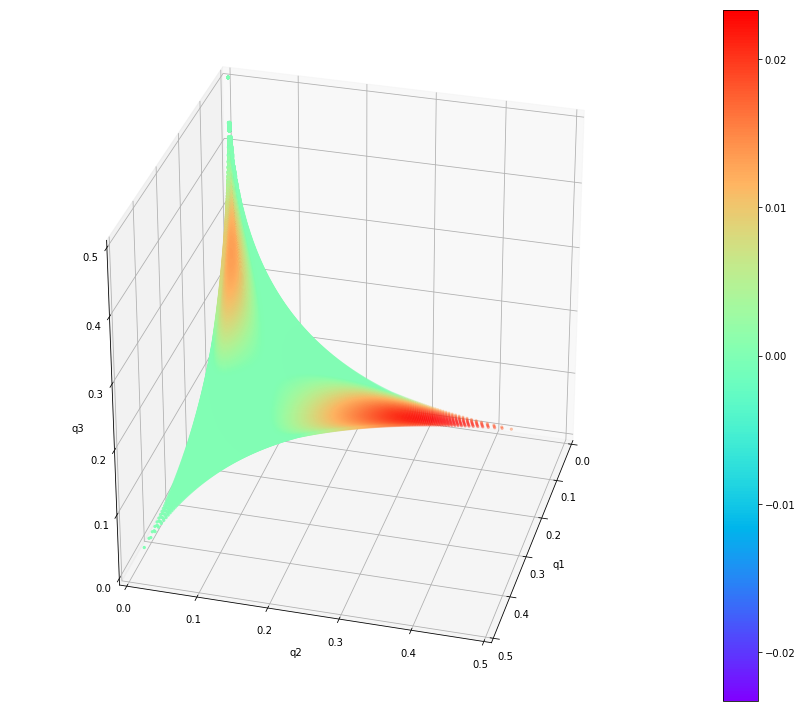

In [403]:
fig = plt.figure(figsize=(12, 10), facecolor='white')
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=30, azim=15)

q1,q2,q3 = qs_best.transpose()
ax.scatter(q1, q2, q3, marker=".", c=viridis(color_mask))

ax.set_xlabel("q1")
ax.set_ylabel("q2")
ax.set_zlabel("q3")

ax.set_xlim(0, .5)
ax.set_ylim(0, .5) 
ax.set_zlim(0, .5)

plt.colorbar(color_map)

plt.tight_layout()
plt.show()